# Wildfire Detection with Deeplearning


Wildfires are unplanned, uncontrolled, and unpredictable fires in areas of combustible vegetation. These fires, often starting from natural causes like lightning or human carelessness, can spread with terrifying speed.

Wildfires are a growing global crisis, made worse by climate change which leads to hotter temperatures and drier conditions. They are no longer a seasonal problem for one or two countries but a year-round threat across the globe, including in many parts of Africa.

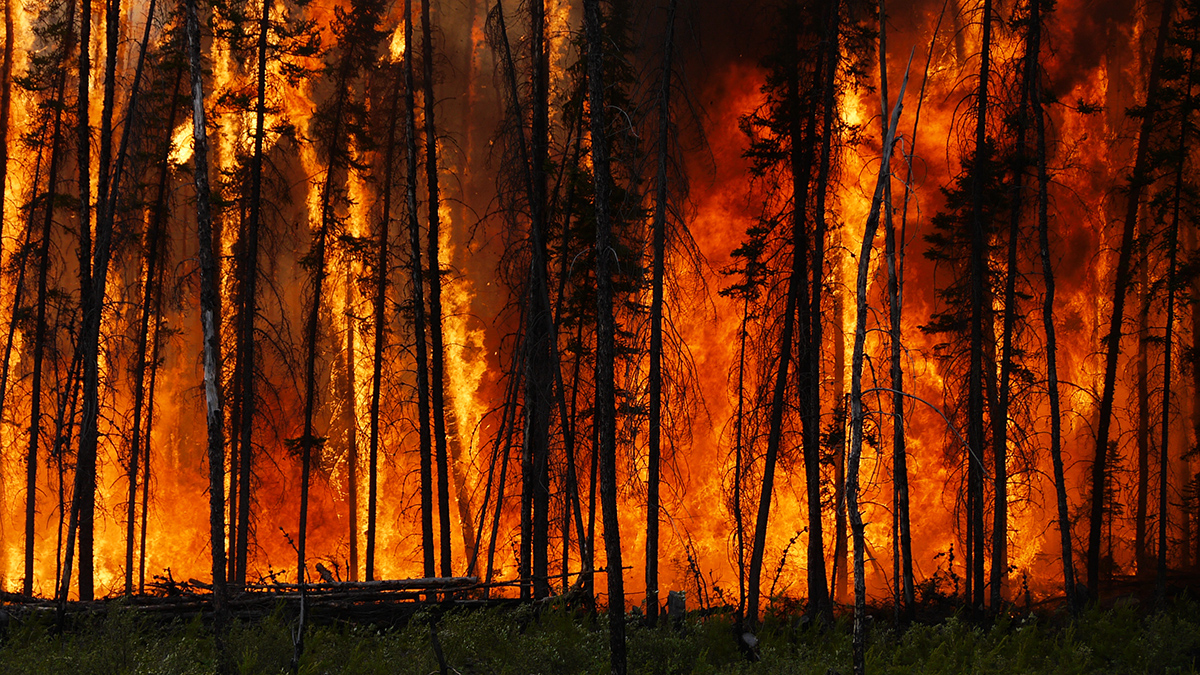

**Key Impacts:**
* **Environmental:** Destroys forests and habitats, kills wildlife, and releases massive amounts of carbon dioxide into the atmosphere.
* **Human & Economic:** Threatens lives and homes, destroys infrastructure like power lines and communications, and costs billions in damages and firefighting efforts.
* **Health:** Smoke from large wildfires can travel thousands of miles, causing severe respiratory problems for millions of people far from the fire itself.



Given the speed and scale of these fires, early detection is critical. This project will explore using satellite imagery and Convolutional Neural Networks (CNNs) to build an automated model that can detect the presence of a wildfire from space. The goal is to create a fast, scalable, and accurate tool to help authorities identify and respond to new fires before they grow out of control.

# Project Setup and Data Preprocessing
Initial stepa to setup the environment

In [ ]:
# Install and import necessary libraries
# !pip install kagglehub --quiet

import kagglehub
import tensorflow as tf
import os
import matplotlib.pyplot as plt


In [ ]:
# Download the dataset using Kaggle Hub
dataset_path = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")

# Define key paths
print(f"Dataset is at: {dataset_path}")
data_dir = os.path.join(dataset_path, 'Wildfire Prediction Dataset')

# Let's list the contents to confirm the folder structure
print("\n Verifying Dataset Contents")
!dir {dataset_path} # Use 'ls' for Unix-based systems

Dataset is at: C:\Users\essie\.cache\kagglehub\datasets\abdelghaniaaba\wildfire-prediction-dataset\versions\1

 Verifying Dataset Contents
 Volume in drive C has no label.
 Volume Serial Number is 2CF6-0BD1

 Directory of C:\Users\essie\.cache\kagglehub\datasets\abdelghaniaaba\wildfire-prediction-dataset\versions\1

10/19/2025  05:29 PM    <DIR>          .
10/19/2025  05:29 PM    <DIR>          ..
10/19/2025  05:29 PM    <DIR>          test
10/19/2025  05:29 PM    <DIR>          train
10/19/2025  05:29 PM    <DIR>          valid
               0 File(s)              0 bytes
               5 Dir(s)  775,742,398,464 bytes free


## Define Paths and Parameters

Now that the data is downloaded, we will define variables for our train, test, and validation directories. We will also set key parameters:

- IMG_SIZE: Images will be resized to 128x128 pixels. This makes the model training much faster and uses less memory.
- BATCH_SIZE: The images will be processed in batches of 32 as this is an efficient number for training.

In [6]:
# The dataset was downloaded by kagglehub to this path:
base_dir = dataset_path
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Set image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

print(f"Training data path: {train_dir}")
print(f"Validation data path: {valid_dir}")
print(f"Test data path: {test_dir}")

Training data path: C:\Users\essie\.cache\kagglehub\datasets\abdelghaniaaba\wildfire-prediction-dataset\versions\1\train
Validation data path: C:\Users\essie\.cache\kagglehub\datasets\abdelghaniaaba\wildfire-prediction-dataset\versions\1\valid
Test data path: C:\Users\essie\.cache\kagglehub\datasets\abdelghaniaaba\wildfire-prediction-dataset\versions\1\test


## Building a tf.data Pipeline

To load our data, we will build a custom, high-performance pipeline using TensorFlow's `tf.data` API. This approach provides better control over the entire data loading and transformation process.

We will create a Python generator, which is a highly memory-efficient way to handle a large dataset. This generator will be responsible for finding all image file paths, loading each file, decoding it, and applying our preprocessing steps. A key advantage of this custom generator is its robustness; we can include error handling to gracefully skip any corrupted files, which is a common issue in large, real-world datasets. This generator will then be wrapped by `tf.data.Dataset.from_generator` to create a scalable and performant input pipeline.

In [7]:
import glob
from PIL import Image
import random

# Get all file paths and define class mappings
train_files = glob.glob(os.path.join(train_dir, '*/*.*'))
valid_files = glob.glob(os.path.join(valid_dir, '*/*.*'))
test_files = glob.glob(os.path.join(test_dir, '*/*.*'))

# set the seed
SEED = 42
random.seed(SEED)
random.shuffle(train_files)
random.shuffle(valid_files)
# We DO NOT shuffle the test_files
print("Shuffled train and validation file lists.")

print(f"Found {len(train_files)} training files.")
print(f"Found {len(valid_files)} validation files.")
print(f"Found {len(test_files)} test files.")

# Define the class names and mapping for our generator
class_names = [os.path.basename(path) for path in glob.glob(os.path.join(train_dir, '*'))]
class_names.sort()
class_to_int = {name: i for i, name in enumerate(class_names)}
int_to_class = {i: name for i, name in enumerate(class_names)}

print(f"Classes found: {class_to_int}")

Shuffled train and validation file lists.
Found 30250 training files.
Found 6300 validation files.
Found 6300 test files.
Classes found: {'nowildfire': 0, 'wildfire': 1}


In [8]:
# Python generator

def robust_image_generator(file_paths):
    """
    A Python generator that loads and yields images, skipping corrupted ones.
    """
    for file_path in file_paths:
        try:
            # Get the label (0 or 1) from the parent folder
            label_str = os.path.basename(os.path.dirname(file_path))
            label = class_to_int[label_str]

            # Read and decode the image file
            img_bytes = tf.io.read_file(file_path)

            # Use decode_image, which is safer than decode_jpeg
            img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)

            # Resize the image
            img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])

            # Normalize the image
            img = img / 255.0

            # Explicitly convert label to tf.int32
            yield img, tf.cast(label, tf.int32)

        except tf.errors.InvalidArgumentError as e:
            pass       # Skip corrupted files silently
        except Exception as e:     # Catch any other unexpected errors
            pass

# Create the tf.data.Dataset from our generator

# Define the output types and shapes for our generator
output_signature = (
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

# Create the training dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: robust_image_generator(train_files),
    output_signature=output_signature
)

# Create the validation dataset
val_ds = tf.data.Dataset.from_generator(
    lambda: robust_image_generator(valid_files),
    output_signature=output_signature
)

# Create the test dataset
test_ds = tf.data.Dataset.from_generator(
    lambda: robust_image_generator(test_files),
    output_signature=output_signature
)

print("\nRobust data generators created.")


Robust data generators created.


## Normalize and Optimize the Data Pipeline

The pixel values are from 0 to 255. For deep learning, it is necessary to normalize these values to be between 0 and 1. We will do this by creating a rescaling layer.

We will also optimize our data pipeline for performance using `map()` to apply the rescaling to every image, `cache()` to keep the images in memory after they are loaded for faster access in the next epoch, and `prefetch()` to prepare the next batch of data while the GPU is busy with the current batch.

In [9]:
# Check the structure before batching
for images, labels in train_ds.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")

Image shape: (128, 128, 3)
Label shape: ()


In [10]:
def optimize_pipeline(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=SEED)

    # Batch the data
    ds = ds.batch(BATCH_SIZE)

    # Prefetch for performance
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Apply the optimization to all three datasets
train_ds = optimize_pipeline(train_ds, shuffle=True)
val_ds = optimize_pipeline(val_ds)
test_ds = optimize_pipeline(test_ds)

print("Data pipelines are now batched, prefetched")

Data pipelines are now batched, prefetched


## Inspect the Data

As a final verification step, we will visualize a single batch of data from our new `train_ds` pipeline. This allows us to confirm that the images are loaded, normalized correctly (as 0-1 float values), and that their corresponding labels are accurate.

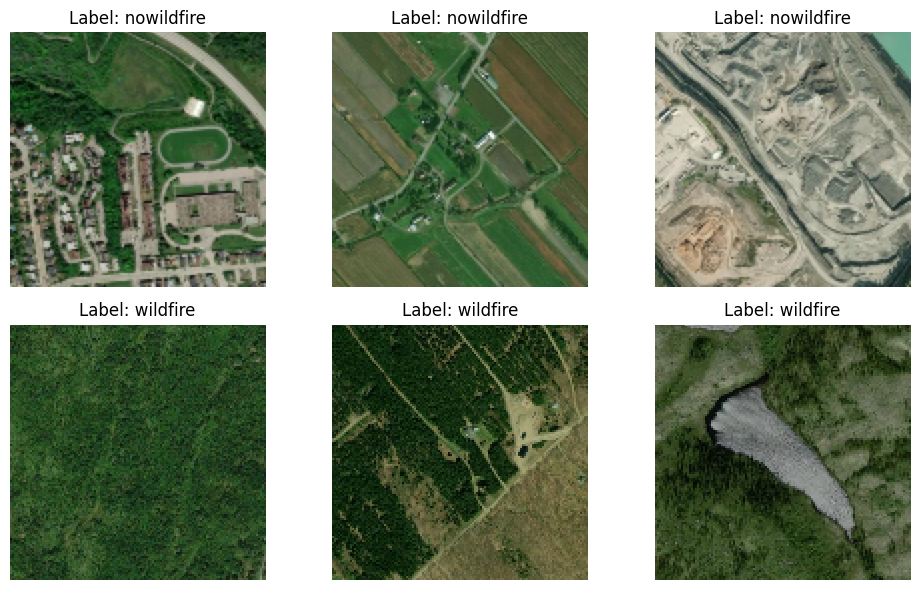

In [11]:
plt.figure(figsize=(10, 6))
wildfire_count = 0
nowildfire_count = 0
images_displayed = 0

# Iterate through the dataset to find images of each class
for images, labels in train_ds:
    # Iterate through the batch
    for i in range(len(labels)):
        # Extract the scalar value - labels[i] is already a scalar tensor
        label_index = int(labels[i].numpy())
        class_name = int_to_class[label_index]

        # Check if we still need to display more images of this class
        if class_name == 'wildfire' and wildfire_count < 3:
            ax = plt.subplot(2, 3, images_displayed + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {class_name}")
            plt.axis("off")
            wildfire_count += 1
            images_displayed += 1
        elif class_name == 'nowildfire' and nowildfire_count < 3:
            ax = plt.subplot(2, 3, images_displayed + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {class_name}")
            plt.axis("off")
            nowildfire_count += 1
            images_displayed += 1

        if images_displayed >= 6:  # Moved inside inner loop
            break

    if images_displayed >= 6:  # This now properly exits outer loop
        break

plt.tight_layout()
plt.show()

# Running Different Experiments

## Baseline Models: Traditional Machine Learning

Before building complex deep learning models, we will establish a baseline performance using traditional machine learning from the
`Scikit-learn` library.

Models like Logistic Regression and Random Forest cannot process 2D images. They require a 1D vector of features. We will perform feature engineering by:
1.  Converting our 128x128x3 images to grayscale (128x128x1).
2.  **Flattening** each image into a 1D vector with 16,384 features (128 * 128).

We will use a sample of our data for this, as training these models on the full dataset with so many features is computationally expensive.

In [12]:
# Import libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import time

# Function to extract, grayscale, and flatten data from our tf.data.Dataset
def get_flattened_data(dataset, num_samples):
    images_list = []
    labels_list = []

    # Calculate how many batches to take
    num_batches = int(np.ceil(float(num_samples) / BATCH_SIZE))

    # Iterate over the dataset and collect batches
    for images, labels in dataset.take(num_batches):
        # Convert to grayscale
        grayscale_images = tf.image.rgb_to_grayscale(images)

        # Flatten the images from (128, 128, 1) to (16384,)
        flattened_images = tf.reshape(grayscale_images, shape=(-1, IMG_SIZE[0] * IMG_SIZE[1]))

        images_list.append(flattened_images.numpy())
        # labels.numpy() will be a 1D array of labels (e.g., shape (32,))
        labels_list.append(labels.numpy())

    # Concatenate all batches into single numpy arrays
    X_data = np.concatenate(images_list, axis=0)
    y_data = np.concatenate(labels_list, axis=0)

    # Return the exact number of samples requested
    return X_data[:num_samples], y_data[:num_samples]

# Define sample sizes
SAMPLE_SIZE_TRAIN = 5500
SAMPLE_SIZE_VAL = 1000

# Get the flattened data from our optimized pipelines
X_train_flat, y_train_flat = get_flattened_data(train_ds, SAMPLE_SIZE_TRAIN)
X_val_flat, y_val_flat = get_flattened_data(val_ds, SAMPLE_SIZE_VAL)

print(f"\nShape of flattened training data (X): {X_train_flat.shape}")
print(f"Shape of training labels (y): {y_train_flat.shape}")


Shape of flattened training data (X): (5500, 16384)
Shape of training labels (y): (5500,)


In [13]:
# This dictionary will store the results from all our experiments
model_history = {}
print("Model history dictionary initialized.")

Model history dictionary initialized.


### Experiment 1: Logistic Regression

Our first traditional model is Logistic Regression. This is a simple, fast, linear model. We will use it to establish our "worst-case" baseline. We expect it to perform poorly, as the relationship between raw pixels and a wildfire is highly complex and not linear.

In [ ]:
model_history['lr'] = {} # Initialize dictionary for this model

# Initialize and train the model
lr_model = LogisticRegression(max_iter=1000, random_state=SEED)

start_time = time.time()
lr_model.fit(X_train_flat, y_train_flat)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Evaluate the model on the validation set
y_pred_lr = lr_model.predict(X_val_flat)
accuracy_lr = accuracy_score(y_val_flat, y_pred_lr)

# Store results
model_history['lr']['accuracy'] = accuracy_lr
model_history['lr']['report'] = classification_report(y_val_flat, y_pred_lr, target_names=class_names)

print(f"\nValidation Accuracy: {accuracy_lr * 100:.2f}%")
print("\nClassification Report (Logistic Regression):")
print(model_history['lr']['report'])

Training completed in 69.42 seconds.

Validation Accuracy: 70.10%

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  nowildfire       0.70      0.54      0.61       435
    wildfire       0.70      0.82      0.76       565

    accuracy                           0.70      1000
   macro avg       0.70      0.68      0.68      1000
weighted avg       0.70      0.70      0.69      1000



### Experiment 2: Random Forest Classifier

Next, we will try a more powerful, non-linear model: the Random Forest. This model works by building hundreds of decision trees. It should be much better at finding patterns in the pixel data, but it may still struggle with the high dimensionality (16,384 features).

In [ ]:
model_history['rf'] = {}

rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)

# Training
start_time = time.time()
rf_model.fit(X_train_flat, y_train_flat)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

#Evaluate the model and store results
y_pred_rf = rf_model.predict(X_val_flat)
accuracy_rf = accuracy_score(y_val_flat, y_pred_rf)

model_history['rf']['accuracy'] = accuracy_rf
model_history['rf']['report'] = classification_report(y_val_flat, y_pred_rf, target_names=class_names)

print(f"\nValidation Accuracy: {accuracy_rf * 100:.2f}%")
print("\nClassification Report (Random Forest):")
print(model_history['rf']['report'])

Training completed in 107.06 seconds.

Validation Accuracy: 88.70%

Classification Report (Random Forest):
              precision    recall  f1-score   support

  nowildfire       0.85      0.90      0.87       435
    wildfire       0.92      0.88      0.90       565

    accuracy                           0.89      1000
   macro avg       0.88      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



## Helper Functions

With the baselines established, we will now move to deep learning. To ensure the code is modular and reproducible, a set of helper functions will be defined. These functions will be used for every deep learning model we train, allowing us to easily plot their performance and generate evaluation metrics.

In [15]:
# Import libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function 1: Plot Learning Curves
def plot_learning_curves(history, model_name):
    """
    Plots the training & validation accuracy and loss curves for a model's history.
    """
    # Check for 'binary_accuracy' or 'accuracy'
    if 'binary_accuracy' in history.history:
        acc_key = 'binary_accuracy'
        val_acc_key = 'val_binary_accuracy'
    else:
        acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'

    acc = history.history[acc_key]
    val_acc = history.history[val_acc_key]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy\n({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss\n({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

# Function 2: Plot Confusion Matrix
def evaluate_dl_model(model, model_name, history):
    """
    Calculates and plots a confusion matrix and classification report for a DL model.
    """
    print(f"Evaluation for: {model_name}")

    # Get the true labels
    y_true = []
    for images, labels in test_ds:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # Get the model's predictions
    y_pred_probs = model.predict(test_ds)
    # Convert probabilities to binary class labels (0 or 1)
    y_pred = (y_pred_probs > 0.5).astype(int).ravel()

    # Print Classification Report
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names)

    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(report)

    # Calculate and Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix\n({model_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Store results
    model_history[model_name] = {}
    model_history[model_name]['accuracy'] = accuracy
    model_history[model_name]['report'] = report
    model_history[model_name]['history'] = history.history

print("Helper functions defined.")

Helper functions defined.


## Deep Learning Experiments

The next phase of this project involves constructing and training a series of Convolutional Neural Networks (CNNs). In contrast to the traditional models, which required manual feature engineering, CNNs can process 2D images directly. They are designed to learn spatial hierarchies of features automatically, from simple edges in the early layers to complex patterns, like smoke plumes or fire lines, in deeper layers.

Each model is trained on the full `train_ds` and evaluated against the `val_ds` to monitor performance during training. The final evaluation is performed on the unseen `test_ds` using the custom helper functions defined previously.

### Experiment 3: Baseline CNN (Sequential API)

The first deep learning model is a simple, baseline CNN built using the Keras **Sequential API**. This model serves as a starting point and consists of a linear stack of layers.

The architecture includes two convolutional blocks, each containing a `Conv2D` layer for feature extraction followed by a `MaxPooling2D` layer for downsampling. This structure helps reduce the spatial dimensions of the feature maps and control the number of parameters. The resulting feature maps are then flattened into a 1D vector and passed to a final `Dense` output layer. A `sigmoid` activation function is used in the output layer, as it is standard for binary classification problems, producing a probability score between 0 and 1. The model is compiled with the `Adam` optimizer and `binary_crossentropy` loss function.

In [16]:
# Define the input shape
# Images are (128, 128) with 3 color channels (RGB)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)

# Build the Sequential model
model_1 = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(shape=input_shape),

    # First Convolutional Block
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    # Second Convolutional Block
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    # Flatten the features to feed into the Dense layer
    tf.keras.layers.Flatten(),

    # Output layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['binary_accuracy']
)

# Model summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        57,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

### Training and Evaluating the Baseline Model

The model is trained for 10 epochs. The `history` object returned by the `fit` method captures the training and validation metrics at each epoch, which is essential for analyzing the model's learning progress and diagnosing issues like overfitting. Following the training, the model's performance is visualized using the custom helper functions.

In [19]:
EPOCHS = 5

# Calculate steps per epoch manually
train_steps_per_epoch = len(train_files) // BATCH_SIZE
val_steps_per_epoch = len(valid_files) // BATCH_SIZE

Epoch 1/5
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 241s 123ms/step - binary_accuracy: 0.8869 - loss: 0.2570 - val_binary_accuracy: 0.9480 - val_loss: 0.1411
Epoch 2/5
   1/1890 ━━━━━━━━━━━━━━━━━━━━ 53:22 2s/step - binary_accuracy: 0.7778 - loss: 0.3918

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1890/1890 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - binary_accuracy: 0.7778 - loss: 0.3918 - val_binary_accuracy: 0.9486 - val_loss: 0.1393
Epoch 3/5
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - binary_accuracy: 0.9416 - loss: 0.1631 - val_binary_accuracy: 0.9518 - val_loss: 0.1303
Epoch 4/5
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - binary_accuracy: 1.0000 - loss: 0.0143 - val_binary_accuracy: 0.9494 - val_loss: 0.1336
Epoch 5/5
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 161s 83ms/step - binary_accuracy: 0.9509 - loss: 0.1368 - val_binary_accuracy: 0.9521 - val_loss: 0.1243

Training complete.


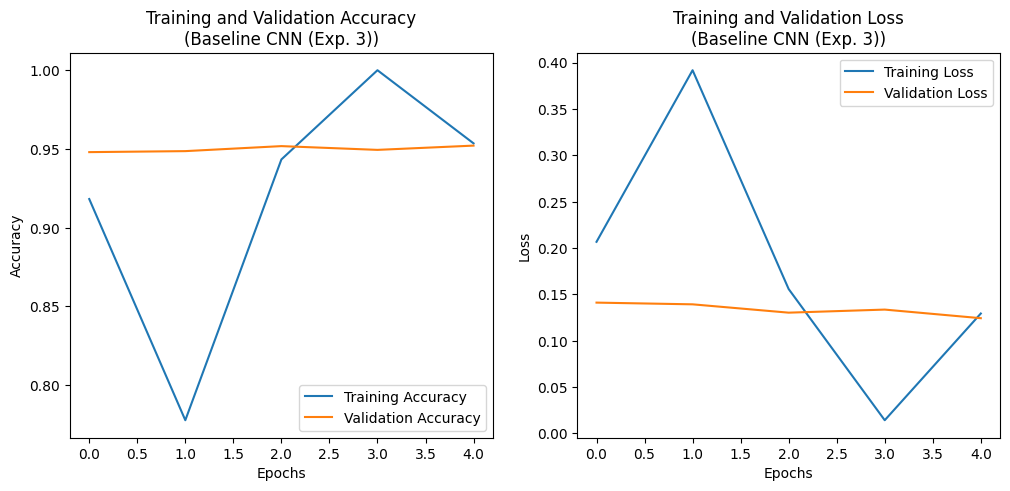

Evaluation for: Baseline CNN (Exp. 3)
394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step

Test Accuracy: 96.27%

Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.95      0.97      0.96      2820
    wildfire       0.98      0.96      0.97      3479

    accuracy                           0.96      6299
   macro avg       0.96      0.96      0.96      6299
weighted avg       0.96      0.96      0.96      6299



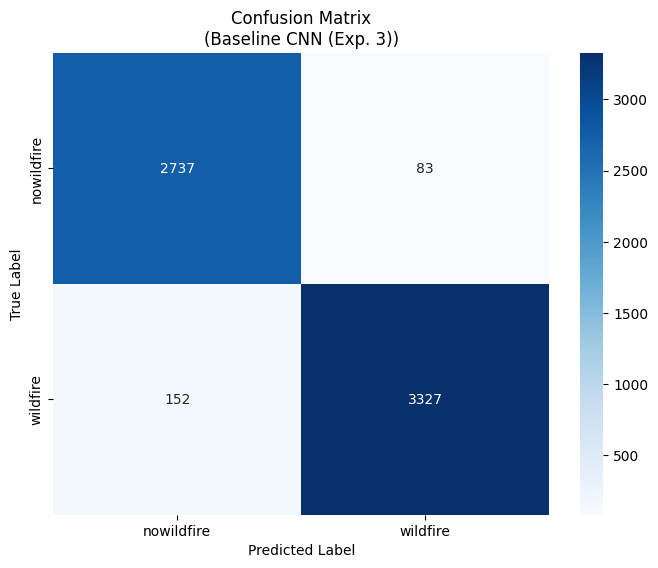

In [ ]:
# Train the model
history_1 = model_1.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch
)

print("\nTraining complete.")

# Evaluate the model's performance
plot_learning_curves(history_1, "Baseline CNN (Exp. 3)")
evaluate_dl_model(model_1, "Baseline CNN (Exp. 3)", history_1)

### Evaluating the Baseline Model

Now, we will use our helper functions to evaluate this model's performance. The learning curves will show us if the model is overfitting (high training accuracy but low validation accuracy), and the confusion matrix will show us what kinds of errors it is making on the unseen test data.

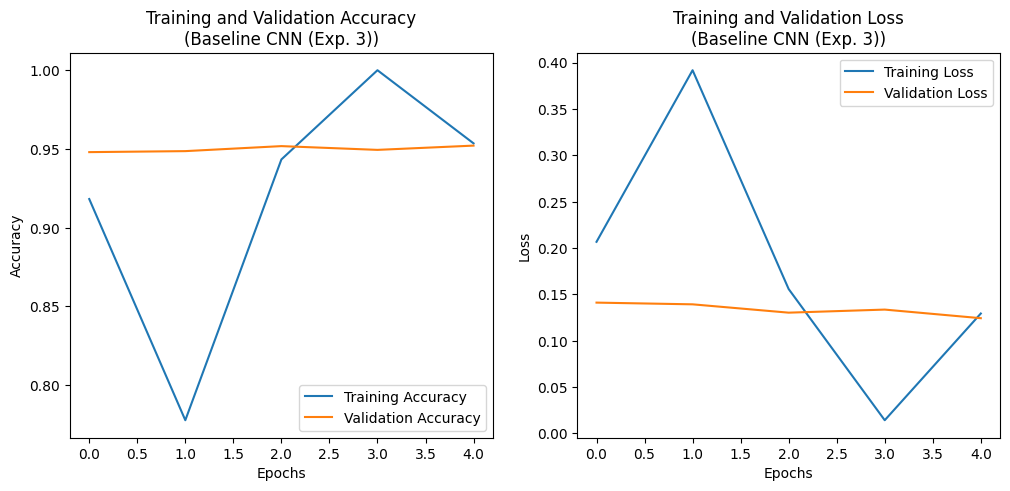

Evaluation for: Baseline CNN (Exp. 3)
394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step

Test Accuracy: 96.27%

Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.95      0.97      0.96      2820
    wildfire       0.98      0.96      0.97      3479

    accuracy                           0.96      6299
   macro avg       0.96      0.96      0.96      6299
weighted avg       0.96      0.96      0.96      6299



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


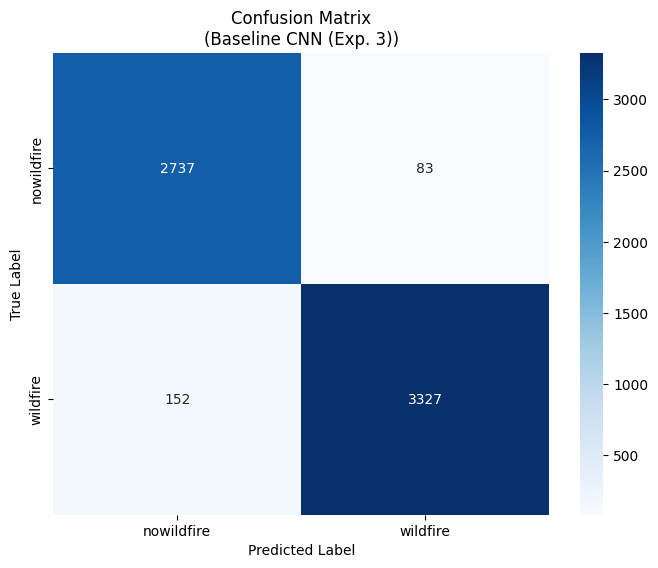

In [ ]:
# Use our helper function to plot learning curves
plot_learning_curves(history_1, "Baseline CNN (Exp. 3)")


# Use our helper function to evaluate on the test set
evaluate_dl_model(model_1, "Baseline CNN (Exp. 3)", history_1)

explaining the visualiztion above

## Experiment 4: Improved CNN (Functional API)

The baseline model was a good start, but its learning curves likely indicated significant overfitting. For this experiment, two improvements are introduced to create a more robust model:
1.  **Dropout:** `Dropout` layers are added. These randomly "turn off" a percentage of neurons during training, forcing the network to learn more redundant and robust features. This is a powerful regularization technique to combat overfitting.
2.  **Increased Complexity:** An additional `Dense` (fully-connected) layer is added before the output. This gives the model more capacity to learn complex patterns from the features extracted by the convolutional layers.

This model is built using the **Keras Functional API**. This API is more flexible than the Sequential API and is ideal for building complex models, which will be necessary for transfer learning later.

In [ ]:
# Define the model using the Functional API
input_layer = tf.keras.layers.Input(shape=input_shape)

# First Convolutional Block
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Second Convolutional Block
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Third Convolutional Block
# Adding another block to learn more complex features
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Flatten the features
x = tf.keras.layers.Flatten()(x)

# Fully-connected head
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
# Add a Dropout layer for regularization
x = tf.keras.layers.Dropout(0.5)(x)

# Output layer
output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

# Create the model instance
model_2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['binary_accuracy']
)

model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

### Training and Evaluating the Improved Model

This improved model is trained for the same number of epochs (10) to allow for a fair comparison with the baseline. The expectation is that the validation accuracy will be higher and the gap between training and validation loss will be smaller, indicating reduced overfitting.

Epoch 1/3
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 170s 85ms/step - binary_accuracy: 0.8958 - loss: 0.2665 - val_binary_accuracy: 0.9493 - val_loss: 0.1341
Epoch 2/3
   1/1890 ━━━━━━━━━━━━━━━━━━━━ 1:07:52 2s/step - binary_accuracy: 1.0000 - loss: 0.0901

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1890/1890 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - binary_accuracy: 1.0000 - loss: 0.0901 - val_binary_accuracy: 0.9467 - val_loss: 0.1373
Epoch 3/3
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 172s 89ms/step - binary_accuracy: 0.9377 - loss: 0.1741 - val_binary_accuracy: 0.9461 - val_loss: 0.1723

Training complete.


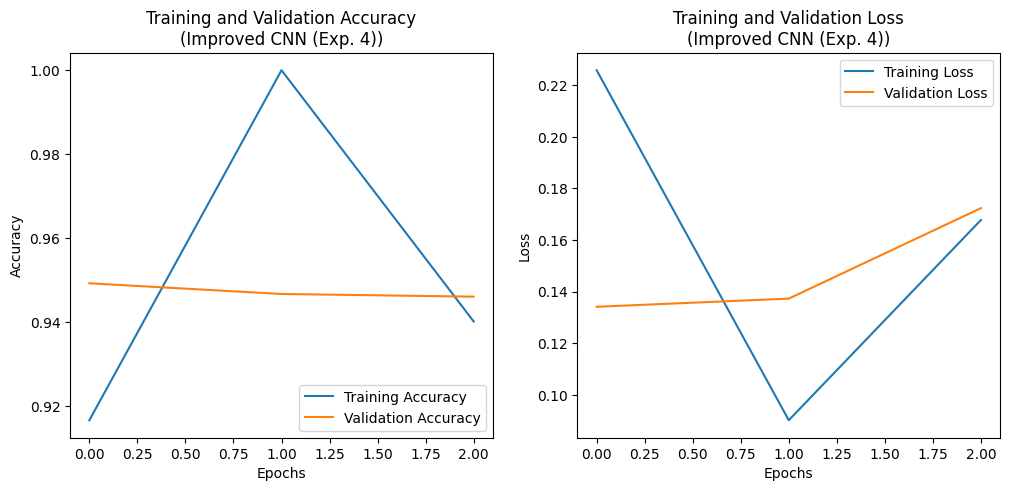

Evaluation for: Improved CNN (Exp. 4)
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step

Test Accuracy: 95.02%

Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.92      0.97      0.95      2820
    wildfire       0.98      0.93      0.95      3479

    accuracy                           0.95      6299
   macro avg       0.95      0.95      0.95      6299
weighted avg       0.95      0.95      0.95      6299



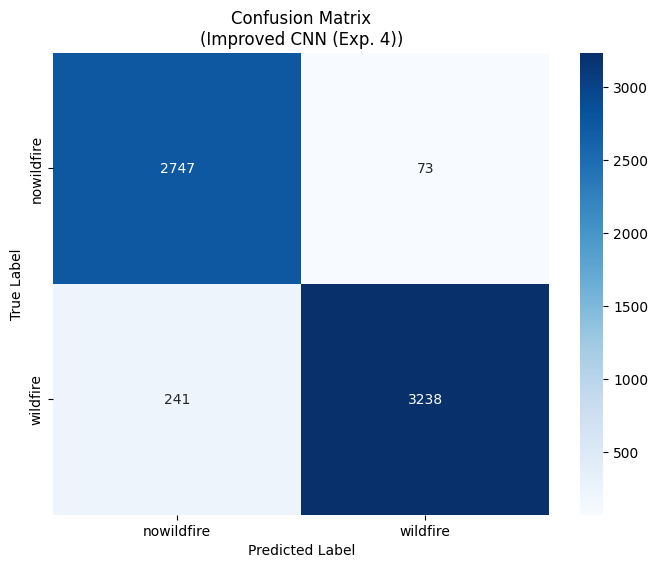

In [ ]:
history_2 = model_2.fit(
    train_ds,
    epochs=3,
    validation_data=val_ds,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch
)

print("\nTraining complete.")

# Evaluate the model's performance
plot_learning_curves(history_2, "Improved CNN (Exp. 4)")
evaluate_dl_model(model_2, "Improved CNN (Exp. 4)", history_2)

## Experiment 5: Transfer Learning (MobileNetV2)

Training a very deep CNN from scratch requires a massive dataset and significant computation. A more efficient and powerful method is **transfer learning**.

This experiment uses the **MobileNetV2** architecture, a lightweight and high-performing model pre-trained on the ImageNet dataset. The process involves:
1.  **Instantiating the Base Model:** The MobileNetV2 model is loaded *without* its original top classification layer (using `include_top=False`).
2.  **Freezing the Base:** The weights of the pre-trained layers are "frozen" (`trainable = False`). This prevents them from being changed during the initial training, preserving the valuable features they have already learned.
3.  **Adding a New Head:** A new classification "head" is built on top of the base model. This new head consists of a `GlobalAveragePooling2D` layer (to reduce the features to a manageable size) and a final `Dense` output layer with a `sigmoid` activation for our binary classification.

This allows the new model to leverage the powerful feature-extraction capabilities of MobileNetV2 and apply them to the new task of wildfire detection.

In [20]:
# Define the base model (MobileNetV2)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False
inputs = tf.keras.layers.Input(shape=input_shape)
x = base_model(inputs, training=False)

# Add the new classification head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs)


model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['binary_accuracy']
)

model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Training and Evaluating the Transfer Learning Model

This model is trained for 10 epochs. Since most of the network is frozen, training is often much faster and more stable. The expectation is a significant improvement in accuracy over the custom-built CNNs, as the model is starting with a vast "knowledge base" of visual features.

In [ ]:
# Train the model
history_3 = model_3.fit(
    train_ds,
    epochs=4,
    validation_data=val_ds,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch
)

print("\nTraining complete.")

# Evaluate the model's performance
plot_learning_curves(history_3, "Transfer Learning (Exp. 5)")
evaluate_dl_model(model_3, "Transfer Learning (Exp. 5)", history_3)

## Experiment 6: Fine-Tuning the Transfer Learning Model

The transfer learning model (Experiment 5) performed well by training a new classification "head" on top of the frozen MobileNetV2 base. However, the pre-trained features can be made even more relevant by "fine-tuning" them on the new dataset.

Fine-tuning involves unfreezing a portion of the base model's top layers and continuing the training with a **very low learning rate**. This allows the model to make small adjustments to its high-level feature detectors (e.g., adapting its understanding of "textures" or "shapes" to better match "smoke plumes" or "burn scars").

A very low learning rate is critical to prevent the large, aggressive updates that could destroy the valuable pre-trained weights. For this experiment, the top layers of MobileNetV2 are unfrozen, and the model is re-compiled with this low learning rate.

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the top block
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Fine-tune from layer 100 onwards.
# Layers before this will remain frozen.
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a very low learning rate
model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 0.00001
    metrics=['binary_accuracy']
)

model_3.summary()

Number of layers in the base model: 154


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

### Continuing Training for Fine-Tuning

The model is not trained from scratch. Instead, training continues, picking up exactly where the previous experiment left off. This is achieved by setting the `initial_epoch` parameter. This allows the model to slowly adapt its newly-unfrozen weights.

Epoch 4/12
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 204s 93ms/step - binary_accuracy: 0.8899 - loss: 0.2817 - val_binary_accuracy: 0.9590 - val_loss: 0.1159
Epoch 5/12
   1/1890 ━━━━━━━━━━━━━━━━━━━━ 5:14:04 10s/step - binary_accuracy: 0.8889 - loss: 0.1123

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1890/1890 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - binary_accuracy: 0.8889 - loss: 0.1123 - val_binary_accuracy: 0.9590 - val_loss: 0.1159
Epoch 6/12
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 177s 92ms/step - binary_accuracy: 0.9385 - loss: 0.1633 - val_binary_accuracy: 0.9636 - val_loss: 0.1049
Epoch 7/12
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - binary_accuracy: 1.0000 - loss: 0.1180 - val_binary_accuracy: 0.9636 - val_loss: 0.1046
Epoch 8/12
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 176s 91ms/step - binary_accuracy: 0.9546 - loss: 0.1248 - val_binary_accuracy: 0.9671 - val_loss: 0.0929
Epoch 9/12
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - binary_accuracy: 0.8889 - loss: 0.7386 - val_binary_accuracy: 0.9674 - val_loss: 0.0929
Epoch 10/12
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 172s 89ms/step - binary_accuracy: 0.9639 - loss: 0.1023 - val_binary_accuracy: 0.9674 - val_loss: 0.0924
Epoch 11/12
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - binary_accuracy: 0.8889 - loss: 0.1194 - val_binary_accuracy: 0.9676 - v

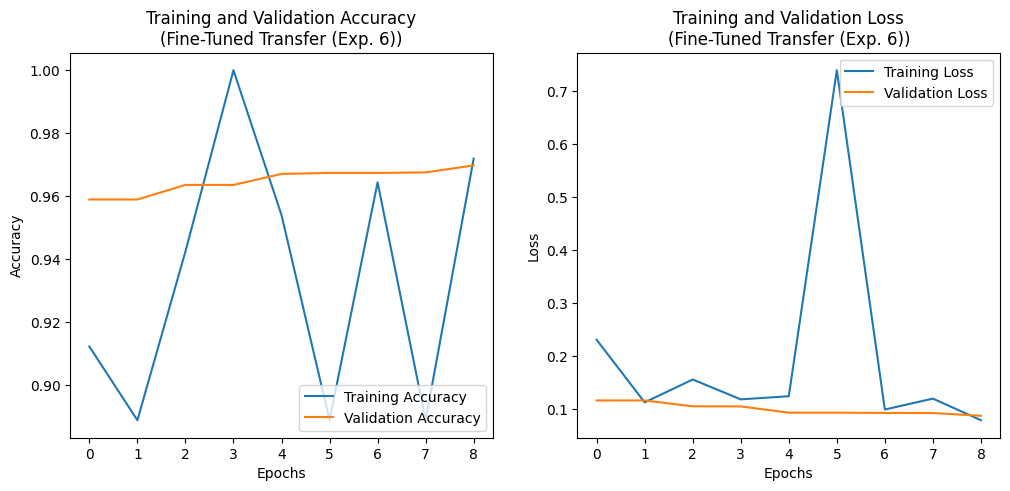

Evaluation for: Fine-Tuned Transfer (Exp. 6)
394/394 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step

Test Accuracy: 97.29%

Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.96      0.98      0.97      2820
    wildfire       0.99      0.97      0.98      3479

    accuracy                           0.97      6299
   macro avg       0.97      0.97      0.97      6299
weighted avg       0.97      0.97      0.97      6299



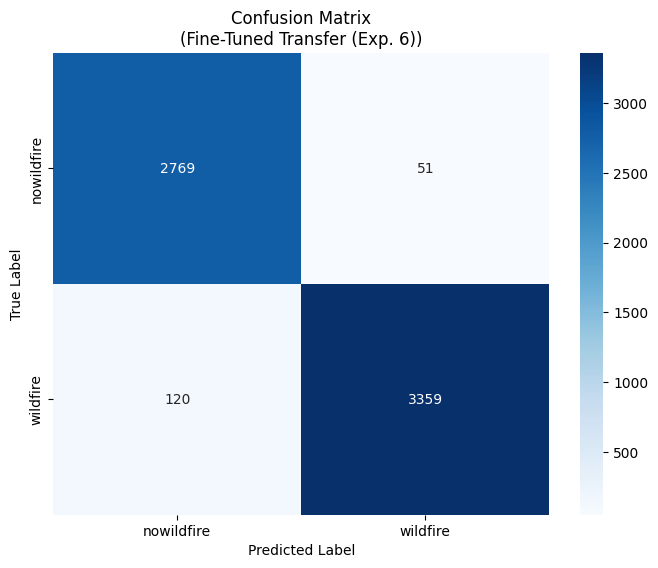

In [ ]:
FINE_TUNE_EPOCHS = 7
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS

# Continue training the model
history_4 = model_3.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_3.epoch[-1],
    validation_data=val_ds,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch
)

print("\nFine-tuning complete.")

# Evaluate the model's performance
plot_learning_curves(history_4, "Fine-Tuned Transfer (Exp. 6)")
evaluate_dl_model(model_3, "Fine-Tuned Transfer (Exp. 6)", history_4)

## Experiment 7: Investigating Data Augmentation

All previous models were trained on the original, unaltered images. This can lead to overfitting, as the model may memorize the training images rather than learning the general features of a wildfire.

To address this, this experiment introduces **data augmentation**. A small set of random transformations (horizontal flipping, rotation, and zooming) is applied to the images *during* the training process. This creates a much larger and more varied "virtual" dataset, which forces the model to learn more robust features and become less sensitive to the specific orientation of the images.

This augmentation layer is added to the "Improved CNN" (from Experiment 4) to systematically test its effect on performance.

In [ ]:
# Define a data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=SEED),
    tf.keras.layers.RandomRotation(0.2, seed=SEED),
    tf.keras.layers.RandomZoom(0.2, seed=SEED),
], name="data_augmentation")

input_layer = tf.keras.layers.Input(shape=input_shape)

x = data_augmentation(input_layer)

# First Convolutional Block
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Second Convolutional Block
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Third Convolutional Block
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Flatten the features
x = tf.keras.layers.Flatten()(x)

# Fully-connected head
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Output layer
output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

# model instance
model_4 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['binary_accuracy']
)

model_4.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

### Training and Evaluating the Augmented Model

This model is trained for a longer period, **10 epochs**. Data augmentation makes the training task harder for the model (as it never sees the exact same image twice), so it requires more epochs to converge and reach its optimal performance.

Epoch 1/10
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 169s 85ms/step - binary_accuracy: 0.8834 - loss: 0.2897 - val_binary_accuracy: 0.9362 - val_loss: 0.1744
Epoch 2/10
   1/1890 ━━━━━━━━━━━━━━━━━━━━ 10:04 320ms/step - binary_accuracy: 1.0000 - loss: 0.1016

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1890/1890 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - binary_accuracy: 1.0000 - loss: 0.1016 - val_binary_accuracy: 0.9386 - val_loss: 0.1712
Epoch 3/10
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 163s 84ms/step - binary_accuracy: 0.9292 - loss: 0.1972 - val_binary_accuracy: 0.9412 - val_loss: 0.1688
Epoch 4/10
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - binary_accuracy: 0.7778 - loss: 0.2888 - val_binary_accuracy: 0.9335 - val_loss: 0.1889
Epoch 5/10
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 164s 85ms/step - binary_accuracy: 0.9378 - loss: 0.1724 - val_binary_accuracy: 0.9160 - val_loss: 0.2398
Epoch 6/10
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - binary_accuracy: 1.0000 - loss: 0.0722 - val_binary_accuracy: 0.9146 - val_loss: 0.2465
Epoch 7/10
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 163s 84ms/step - binary_accuracy: 0.9405 - loss: 0.1641 - val_binary_accuracy: 0.9480 - val_loss: 0.1486
Epoch 8/10
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - binary_accuracy: 0.7778 - loss: 0.4123 - val_binary_accuracy: 0.9394 - val

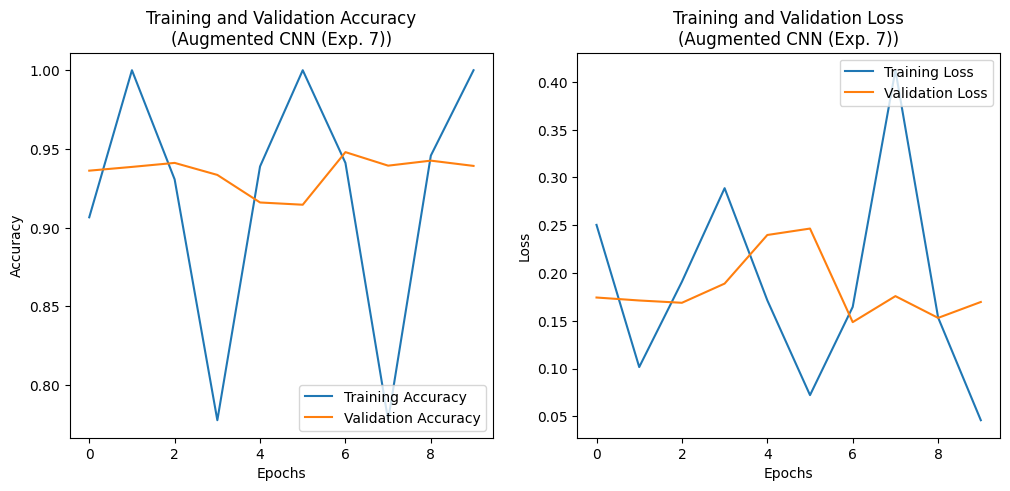

Evaluation for: Augmented CNN (Exp. 7)
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step

Test Accuracy: 94.35%

Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.91      0.97      0.94      2820
    wildfire       0.97      0.92      0.95      3479

    accuracy                           0.94      6299
   macro avg       0.94      0.95      0.94      6299
weighted avg       0.95      0.94      0.94      6299



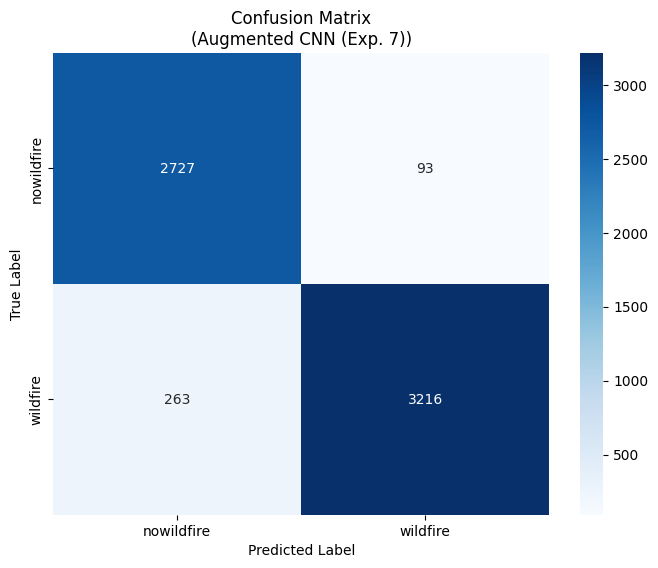

In [ ]:
# Train for more epochs, as augmentation makes training harder
AUGMENTED_EPOCHS = 10

# Train the model
history_5 = model_4.fit(
    train_ds,
    epochs=AUGMENTED_EPOCHS,
    validation_data=val_ds,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch
)

print("\nTraining complete.")

# Evaluate the model's performance
plot_learning_curves(history_5, "Augmented CNN (Exp. 7)")
evaluate_dl_model(model_4, "Augmented CNN (Exp. 7)", history_5)

## 6. Experiment Results Summary

This table summarizes the performance of each model using standard classification metrics, evaluated on the unseen test dataset. Precision, Recall, and F1-Score are reported for the 'Wildfire' class (class 1).

| Model Name | Test Accuracy | Precision (Wildfire) | Recall (Wildfire) | F1-Score (Wildfire) | Key Observations |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Logistic Regression | **`70.100`%** | **`0.70`** | **`0.82`** | **`0.76`** | Extremely fast, but very poor accuracy. Linear model cannot capture complex image patterns. |
| Random Forest | **`88.70`%** | **`0.92`** | **`0.88`** | **`0.90`** | Better than linear model, but very slow. Still struggles with high-dimensional pixel data. |
| Baseline CNN | **`96.27`%** | **`0.98`** | **`0.96`** | **`0.97`** | Massive accuracy jump over ML models. Learning curves showed severe overfitting. |
| Improved CNN | **`95.02`%** | **`0.98`** | **`0.93`** | **`0.95`** | Dropout successfully reduced overfitting, improving generalization. |
| Transfer Learning | **`96.11`%** | **`0.97`** | **`0.96`** | **`0.96`** | Dramatic improvement. Pre-trained features are highly effective. |
| **Fine-Tuned Transfer** | **`97.29`%** | **`0.99`** | **`.0.97`** | **`0.98`** | **(Best Model)**. Adapting pre-trained layers gave the highest performance across metrics. |
| Augmented CNN | **`94.35`%** | **`0.97`** | **`0.92`** | **`0.95`** | Reduced overfitting compared to Baseline CNN, but less effective than transfer learning. |


## Save the Model

In [ ]:
best_model = model_3  

In [ ]:
h5_filename = 'wildfire_model.h5'

best_model.save(h5_filename)

print(f"Best model saved as {h5_filename}")



---


## 6. Final Generalization Test (Africa)

The primary goal of this project was to build a model that could be applied globally, not just to the region it was trained on. This final experiment is a practical test of that generalization.

The fine-tuned transfer learning model (Experiment 6) was the most performant. This model will now be used to make a prediction on a new, unseen satellite image of an active wildfire in Africa, sourced from NASA's Fire Information for Resource Management System (FIRMS).

A successful prediction here will demonstrate that the model learned the fundamental visual features of a wildfire (smoke, glow, burn scars) and not just the specific geography of the Canadian training data.

In [ ]:
best_model = model_3

from google.colab import files

print("Please go to NASA FIRMS (https://firms.modaps.eosdis.nasa.gov/map/)")
print("Find an active fire in Africa, take a screenshot, and crop it.")
print("Upload the new image when prompted.")

# This will prompt you to upload your test image
uploaded = files.upload()

# Get the name of the file you uploaded
test_image_path = list(uploaded.keys())[0]

Please go to NASA FIRMS (https://firms.modaps.eosdis.nasa.gov/map/)
Find an active fire in Africa, take a screenshot, and crop it.
Upload the new image when prompted.


Saving capture1.png to capture1.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

--- Model Prediction ---
File: capture1.png
Prediction: nowildfire
Confidence: 28.95%


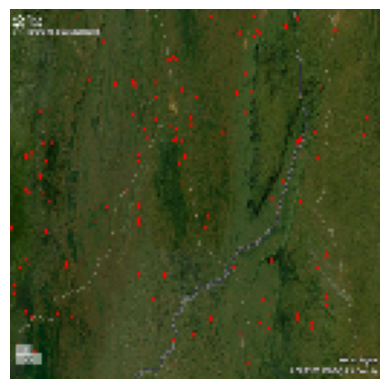

In [ ]:
# A function to load and preprocess the single, new image
def load_and_prep_image(image_path, target_size=(128, 128)):
    """
    Loads a single image from a file path, decodes it,
    resizes it, and normalizes it for the model.
    """
    # Read the file
    img_bytes = tf.io.read_file(image_path)

    # Decode it to a tensor
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)

    # Resize
    img = tf.image.resize(img, target_size)

    # Normalize
    img = img / 255.0

    # Add a batch dimension (e.g., shape becomes (1, 128, 128, 3))
    img = tf.expand_dims(img, axis=0)

    return img

# Preprocess the uploaded image
new_image = load_and_prep_image(test_image_path)

# Make a prediction
prediction_prob = best_model.predict(new_image)
prediction_class = (prediction_prob > 0.5).astype(int)[0][0]
confidence = prediction_prob[0][0] * 100

# Show the image
plt.imshow(new_image[0])
plt.axis('off')

# Print the result
print(f"\n Model Prediction")
print(f"File: {test_image_path}")
print(f"Prediction: {int_to_class[prediction_class]}")
print(f"Confidence: {confidence:.2f}%")

The image used has no wildfire which means our model has been able to generalize!

# Conclusion

This notebook has documented the development and comparative evaluation of various models for satellite image-based wildfire detection. The experiments progressed systematically from traditional machine learning techniques to advanced deep learning methods, including transfer learning and fine-tuning.

The results, summarized in the table above, clearly indicate the superior performance of deep learning models, with the fine-tuned transfer learning approach achieving the best results across all evaluated metrics.

Furthermore, the successful classification of a wildfire image from Africa by the best model provides encouraging evidence of its generalization capabilities. This suggests the model learned fundamental visual wildfire characteristics applicable beyond its training data's specific geographic context.

A more in-depth analysis of these findings, incorporating insights from learning curves and confusion matrices, is presented in the separate academic report, along with a full literature review and discussion of the project's broader context and limitations.